# Categorization Variables

Since VBF has a *preference* for $\Delta \eta_{hh}$ over $|\cos\Theta^*|$, and ggF did not see a major improvement for $|\cos\Theta^*|$ over $\Delta \eta_{hh}$, we will probably stick with $\Delta \eta_{hh}$, but it *might* be nice to see some more follow-up plots on this as well??

Also, the paper Caterina pointed me to for the motivation for the angular cateogrization was this [di-jets paper](https://arxiv.org/abs/1910.08447), and they were *actually* categorizing in rapidity, *not* pseudo-rapidity.

Also, Michael had mentioned that this woul be an interesting thing to check... so I'm *on it*!!

In [20]:
import pandas as pd
import numpy as np
from itertools import product
from glob import glob 

import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray as tlv

import os
os.sys.path += ['../RRevolution/code/','../code',"../PAG-opt/","../PyATLASstyle/"]
from analysis import getXhh
from utils import fileDirSLAC as fileDir, mcToYr, L
from eventDisplays import rainbow_text

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
x1,y1 = 124,117

In [11]:
hc_cols = ['pT_h1','eta_h1','phi_h1','m_h1',
           'pT_h2','eta_h2','phi_h2','m_h2']

cols=['m_hh','ntag','dEta_hh','cos_theta_star']+hc_cols


In [25]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind/ntag_4b'
rwTag = f'_min_dR_VEC_sr_{x1}_{y1}_NN_100_bootstraps'

tName = 'sig'


f16 = uproot.open(f'{fDir}/data16{rwTag}.root')
b16 = f16[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_16'])

f17 = uproot.open(f'{fDir}/data17{rwTag}.root')
b17 = f17[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_17'])

f18 = uproot.open(f'{fDir}/data18{rwTag}.root')
b18 = f18[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_18'])


# Apply the normalization correction to the weights
for yr,bdf,f in zip([16,17,18],[b16,b17,b18],[f16,f17,f18]):
    bdf['w_2b'] = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']
        
    h1 = tlv.from_ptetaphim(*bdf[['pT_h1','eta_h1','phi_h1','m_h1']].values.T)
    h2 = tlv.from_ptetaphim(*bdf[['pT_h2','eta_h2','phi_h2','m_h2']].values.T)
    
    bdf['y_h1'] = h1.rapidity
    bdf['y_h2'] = h2.rapidity
    bdf['dy'] = abs(h1.rapidity - h2.rapidity)
    #break
        
# Recall - Sean's already applied the VBF veto
b16 = b16[b16.ntag==2]
b17 = b17[b17.ntag==2]
b18 = b18[b18.ntag==2]

In [21]:
sFile = '../data/RR/NNT_DEC20_MDR_VEC/MC/600043_mc16{}/NanoNTuple.root'

tName = 'fullmassplane'
scols=['pass_vbf_sel','mc_sf','truth_mhh']

s16 = uproot.open(sFile.format('a'))[tName].pandas.df(cols+scols)
s17 = uproot.open(sFile.format('d'))[tName].pandas.df(cols+scols)
s18 = uproot.open(sFile.format('e'))[tName].pandas.df(cols+scols)

# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
for yr,sdf in zip([16,17,18],[s16,s17,s18]):
    sdf['mc_sf']     *= L[yr]
    sdf['truth_mhh'] *= 0.001
    
    sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)
    
    h1 = tlv.from_ptetaphim(*sdf[['pT_h1','eta_h1','phi_h1','m_h1']].values.T)
    h2 = tlv.from_ptetaphim(*sdf[['pT_h2','eta_h2','phi_h2','m_h2']].values.T)
    
    sdf['y_h1'] = h1.rapidity
    sdf['y_h2'] = h2.rapidity
    sdf['dy'] = abs(h1.rapidity - h2.rapidity)
        
s16 = s16[(s16.Xhh_new < 1.6) & (s16.ntag>=4) & (~s16.pass_vbf_sel)]
s17 = s17[(s17.Xhh_new < 1.6) & (s17.ntag>=4) & (~s17.pass_vbf_sel)]
s18 = s18[(s18.Xhh_new < 1.6) & (s18.ntag>=4) & (~s18.pass_vbf_sel)]

## Correlation b/w these variables in the SR

In [43]:
text = "$\mathbf{ATLAS}$ Internal\n"
text += "min_dR, $\Delta \eta_{hh}$ < 1.5, X_wt_tag, res buckets"

In [135]:
sdfs = [s16,s17,s18]
bdfs = [b16,b17,b18]''
yrs  = [16,17,18]

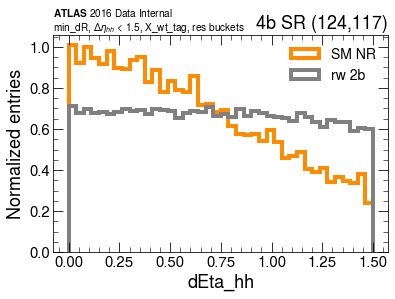

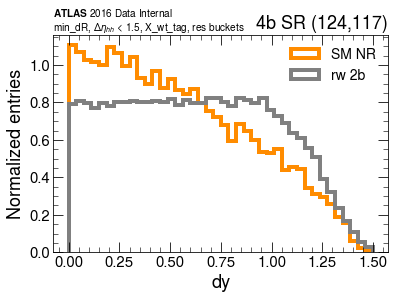

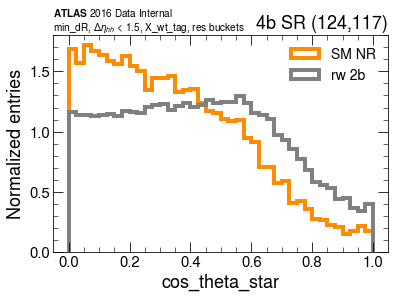

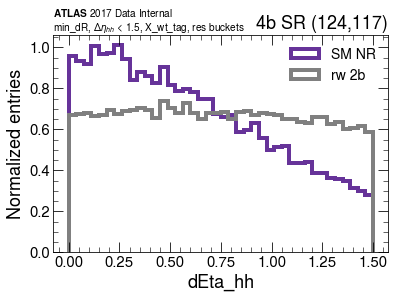

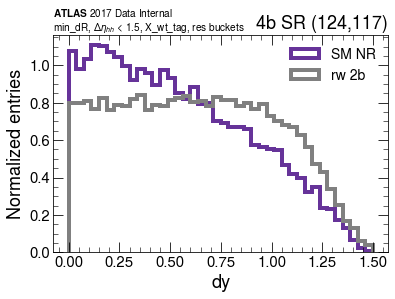

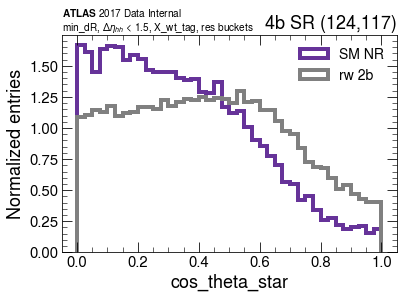

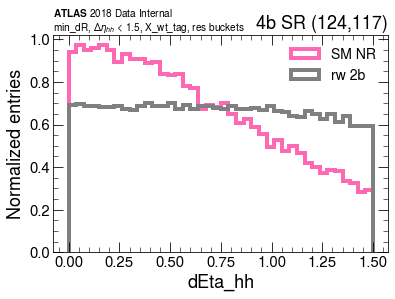

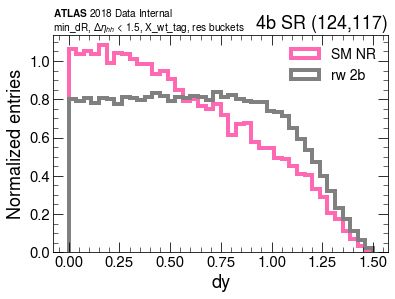

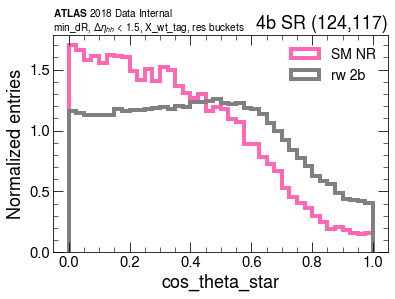

In [70]:
kwargs = {'histtype':'step','lw':4,'density':True}

for sdf,bdf,c,yr in zip(sdfs,bdfs,['darkorange','rebeccapurple','hotpink'],yrs):
    
    for v,r in zip(['dEta_hh','dy','cos_theta_star'],[[0,1.5],[0,1.5],[0,1]]):
        
        plt.figure()
        
        plt.hist(sdf[v],40,r,label='SM NR',color=c,**kwargs, 
                 weights=sdf.mc_sf)
        plt.hist(bdf[v],40,r,label='rw 2b',color='grey',**kwargs,weights=bdf.w_2b)
        
        plt.xlabel(v,fontsize=18)
        plt.ylabel('Normalized entries',fontsize=18)
        plt.legend()
        
        ax = plt.gca()
        ti=text.replace('Int', f'20{yr} Data Int')
        plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
        plt.title(f'4b SR ({x1},{y1})',loc='right')

**Thoughts:**
1. It seems like dy is a smaller variable, but I think this makes sense b/c $\Delta \eta$ increases as the HH become more separated in $\phi$.

In [67]:
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

Text(0, 0.5, 'dy')

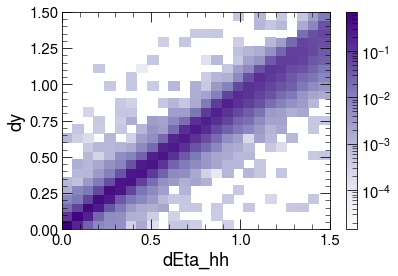

In [68]:
plt.hist2d(*sdf[['dEta_hh','dy']].values.T,25,[[0,1.5],[0,1.5]],
           cmap='Purples',norm=LogNorm(),weights=sdf.mc_sf)

plt.colorbar()
plt.xlabel('dEta_hh',fontsize=18)
plt.ylabel('dy',fontsize=18)

Text(0, 0.5, 'dy')

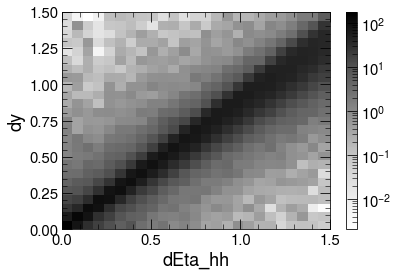

In [73]:
plt.hist2d(*bdf[['dEta_hh','dy']].values.T,25,[[0,1.5],[0,1.5]],
           cmap='Greys',norm=LogNorm(),weights=bdf.w_2b)

plt.colorbar()
plt.xlabel('dEta_hh',fontsize=18)
plt.ylabel('dy',fontsize=18)

(0.0, 1.5)

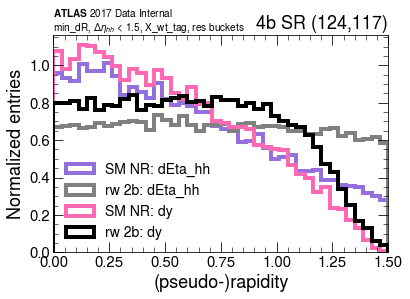

In [77]:
sdf,bdf = s17,b17
yr=17

n,r = 40, (0, 1.5)

for v,cs,cb in zip(['dEta_hh','dy'],['mediumpurple','hotpink'],
                   ['grey','k']):

    #plt.figure()

    plt.hist(sdf[v],n,r,label=f'SM NR: {v}',color=cs,**kwargs,weights=sdf.mc_sf)
    plt.hist(bdf[v],n,r,label=f'rw 2b: {v}',color=cb,**kwargs,weights=bdf.w_2b)

plt.xlabel('(pseudo-)rapidity',fontsize=18)
plt.ylabel('Normalized entries',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
ti=text.replace('Int', f'20{yr} Data Int')
plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.title(f'4b SR ({x1},{y1})',loc='right')
plt.xlim(0,1.5)

**Thoughts:**
1. The signal is *definitely* more peaked for dy
2. But, it *does* seem like the background is more peaked as well, but it is (I guess) important to remember that the plot above was *normalized* for both signal and background.

In [92]:
figDir = 'figures/rapidityChecks/'

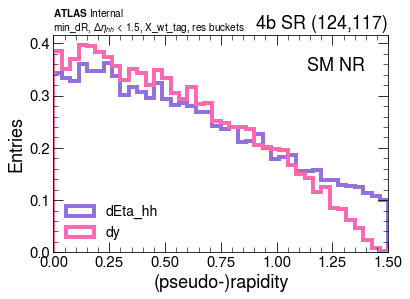

In [93]:
for v,cs in zip(['dEta_hh','dy'],['mediumpurple','hotpink']):

    plt.hist(sdf[v],n,r,label=v,color=cs,weights=sdf.mc_sf,
             histtype='step',lw=4)
    
plt.xlabel('(pseudo-)rapidity',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.text(.93,.9,'SM NR',ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.title(f'4b SR ({x1},{y1})',loc='right')
plt.xlim(0,1.5)

plt.savefig(f'{figDir}/sm17.pdf')

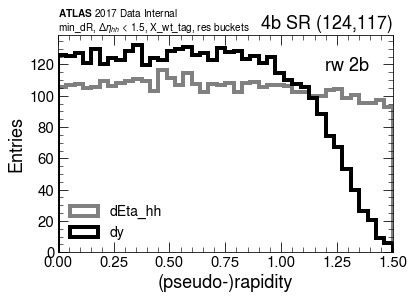

In [97]:
for v,cb in zip(['dEta_hh','dy'], ['grey','k']):

    plt.hist(bdf[v],n,r,label=v,color=cb,weights=bdf.w_2b,
             histtype='step',lw=4)

plt.xlabel('(pseudo-)rapidity',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
ti=text.replace('Int', f'20{yr} Data Int')
plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.text(.93,.9,'rw 2b',ha='right',va='top',transform=ax.transAxes,fontsize=18)
plt.title(f'4b SR ({x1},{y1})',loc='right')
plt.xlim(0,1.5)

plt.savefig(f'{figDir}/rw2b17.pdf')

For funsies - let's *peek* at $\kappa_\lambda = 5$ as well!

In [89]:
from processMNTs import getLambdaWeights

In [90]:
getLambdaWeights(s17)

6.434938474485086
6.4324848200068345


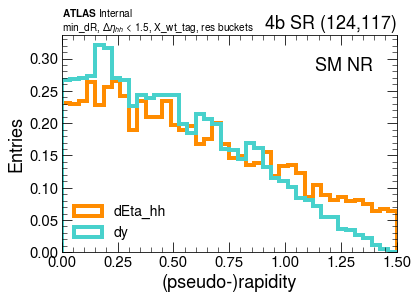

In [96]:
for v,cs in zip(['dEta_hh','dy'],['darkorange','mediumturquoise']):

    s,_,_ = plt.hist(sdf[v],n,r,label=v,color=cs,weights=sdf.w_k5,
                     histtype='step',lw=4)
    print(np.sum(s))
plt.xlabel('(pseudo-)rapidity',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.legend(loc='lower left')

ax = plt.gca()
plt.text(0,1,text,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
plt.text(.93,.9,'SM NR',ha='right',va='top',transform=ax.transAxes,fontsize=18)

plt.title(f'4b SR ({x1},{y1})',loc='right')
plt.xlim(0,1.5)

plt.savefig(f'{figDir}/kl5_17.pdf')

Ok, so this isn't looking promising since the bkg yield gets quite a bit higher, but I think it's probably worthwhile to pop out some significance estimates since @ the end of the day we do an $m_{hh}$ fit.

**Let's do 3 $\Delta \eta$ (or $\Delta y$) bins**

In [155]:
eta_edgs = [0, 0.5, 1, 1.5]
edg_str = '_'.join([str(e) for e in eta_edgs])


cs = [f'{v}: ({emin},{emax})' for emin,emax in zip(eta_edgs[:-1],eta_edgs[1:]) 
      for v in ['dEta_hh','dy']]

z_df = pd.DataFrame(0,yrs+['comb'],cs)


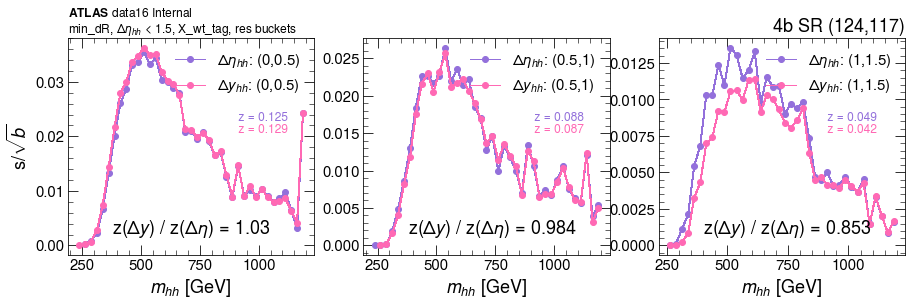

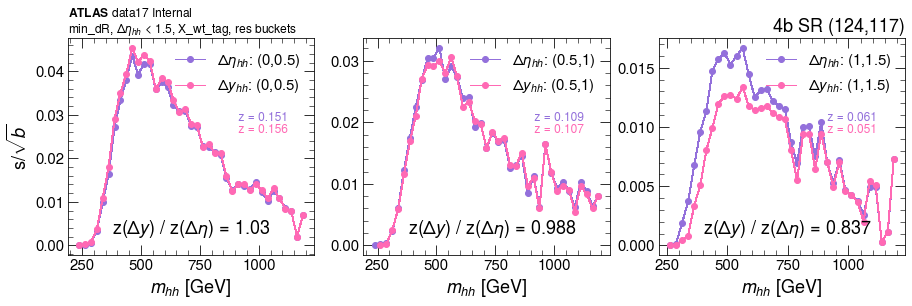

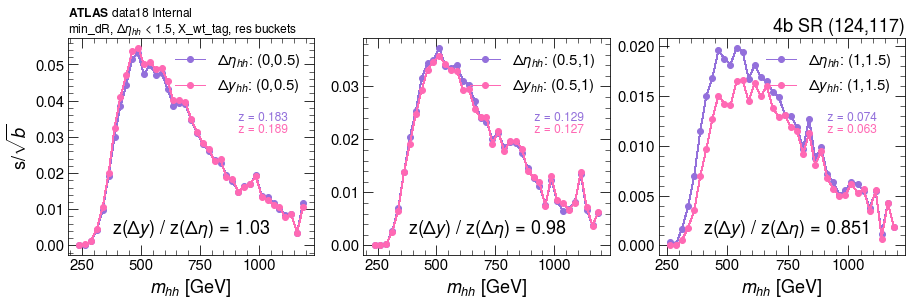

In [157]:
for sdf,bdf,yr in zip(sdfs, bdfs, yrs):
    
    fig,axes = plt.subplots(1,len(eta_edgs)-1,figsize=(15,4))

    n,r = 40,(200,1200)
    
    for ax,emin,emax in zip(axes,eta_edgs[:-1],eta_edgs[1:]):
        
        zs = []
        
        ls = []
        lc = ['mediumpurple','hotpink']

        for v,l,ci in zip(['dEta_hh','dy'],['$\Delta \eta_{hh}$','$\Delta y_{hh}$'],lc):

            smask = (sdf[v] > emin) & (sdf[v] < emax)
            bmask = (bdf[v] > emin) & (bdf[v] < emax)

            s,e = np.histogram(sdf.loc[smask,'m_hh'],n,r, weights=sdf.loc[smask,'mc_sf'])
            b,_ = np.histogram(bdf.loc[bmask,'m_hh'],n,r, weights=bdf.loc[bmask,'w_2b'])

            
            xx = 0.5 * (e[1:] + e[:-1])
            z = s[b!=0]/np.sqrt(b[b!=0])

            ax.plot(xx[b!=0],z,lw=1,marker='o',color=ci, label=f'{l}: ({emin},{emax})')
            zi = np.sqrt(np.sum(z**2))
            ls.append(f'z = {zi:.3f}')
            
            z_df.loc[yr,f'{v}: ({emin},{emax})'] = zi
            zs.append(zi)
            
        ax.text(.18,.1,'z($\Delta y$) / z($\Delta \eta$) = '+f'{zs[1]/zs[0]:.3}',
                transform=ax.transAxes,fontsize=18)

        ax.legend(loc='upper right',fontsize=15)
        ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)

        _,ymax = ax.get_ylim()
        rainbow_text(900,0.6*ymax,ls,lc,yoffset=1,ax=ax,fontsize=12)
    
    axes[0].set_ylabel('s$ / \sqrt{b}$',fontsize=18)

    plt.title(f'4b SR ({x1},{y1})',loc='right')
    ti = text.replace('Int',f'data{yr} Int')
    axes[0].text(0,1,ti,transform=axes[0].transAxes,fontsize=12,va='bottom' )

    
    plt.savefig(f'{figDir}/sigs{yr}_cats_{edg_str}.pdf',bbox_inches='tight')
    plt.show()
    #break

**Save the corresponding table**

In [164]:
z_df.loc['comb',z_df.columns] = np.sqrt(np.sum(z_df.loc[yrs,z_df.columns].values **2,axis=0))

In [166]:
ecols = [f'dEta_hh: ({emin},{emax})' for emin,emax in zip(eta_edgs[:-1],eta_edgs[1:])]
ycols = [f'dy: ({emin},{emax})' for emin,emax in zip(eta_edgs[:-1],eta_edgs[1:])]

In [169]:
z_df['dEta_hh cats'] = np.sqrt(np.sum(z_df[ecols].values**2,axis=1))
z_df['dy cats'] = np.sqrt(np.sum(z_df[ycols].values**2,axis=1))

In [172]:
z_df.round(4)

dEta_hh: (0,0.5)  dy: (0,0.5)  dEta_hh: (0.5,1)  dy: (0.5,1)  \
16              0.1255       0.1287            0.0884       0.0869   
17              0.1512       0.1557            0.1087       0.1073   
18              0.1828       0.1885            0.1294       0.1268   
comb            0.2684       0.2763            0.1907       0.1875   

      dEta_hh: (1,1.5)  dy: (1,1.5)  dEta_hh cats  dy cats  
16              0.0495       0.0422        0.1612   0.1609  
17              0.0608       0.0509        0.1958   0.1958  
18              0.0736       0.0626        0.2358   0.2357  
comb            0.1075       0.0910        0.3463   0.3461

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:35: 

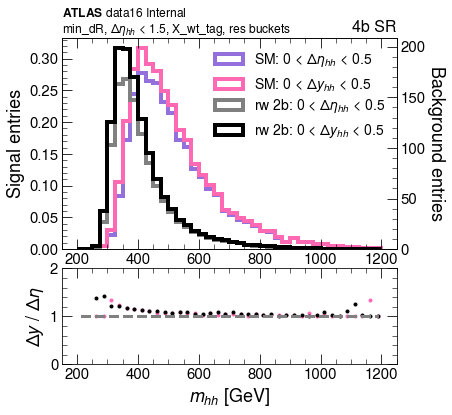

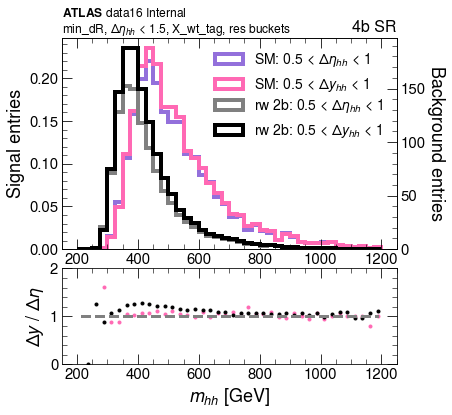

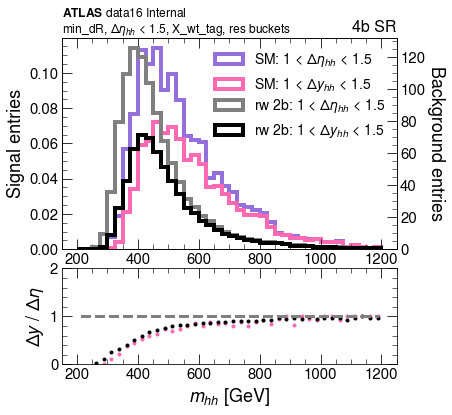

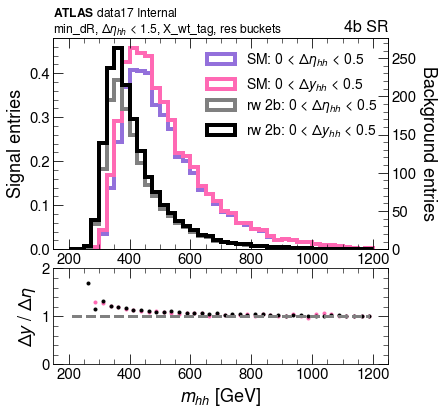

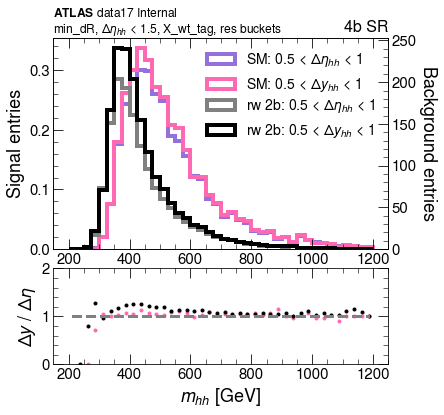

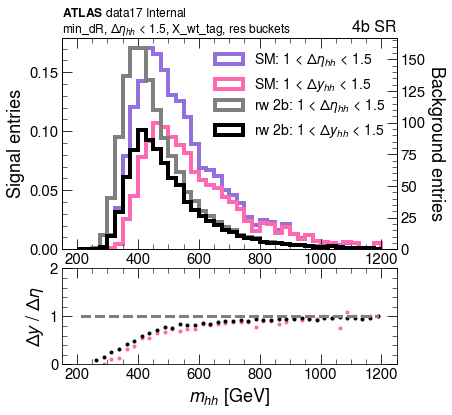

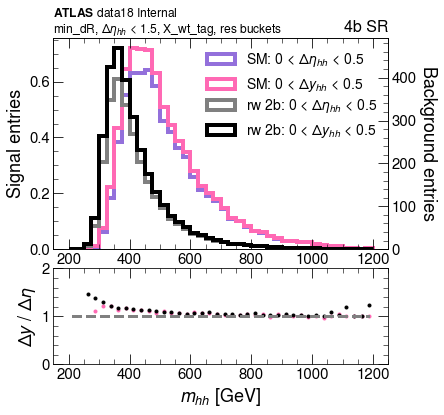

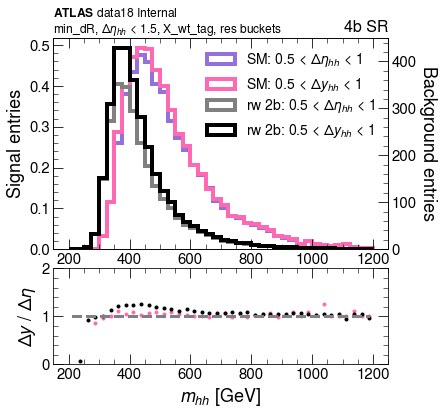

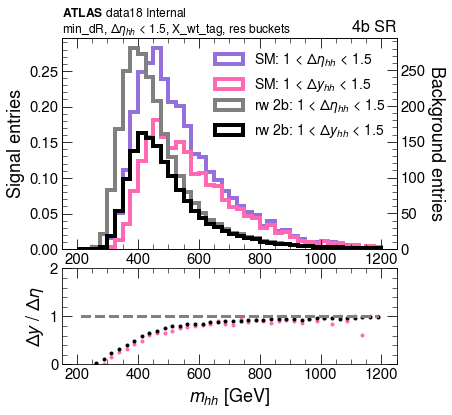

In [173]:
for sdf,bdf,yr in zip(sdfs, bdfs, yrs):

    for emin, emax in zip(eta_edgs[:-1],eta_edgs[1:]):

        fig = plt.figure(figsize=(6,6))
        gs = gridspec.GridSpec(3,1)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = ax1.twinx()
        ax3 = fig.add_subplot(gs[2,0],sharex=ax1)

        ls = []
        lc = []

        s_hists = []
        b_hists = []

        for v,l,cs,cb in zip(['dEta_hh','dy'],['$\Delta \eta_{hh}$','$\Delta y_{hh}$'],
                             ['mediumpurple','hotpink'],['grey','k']):

            smask = (sdf[v] > emin) & (sdf[v] < emax)
            bmask = (bdf[v] > emin) & (bdf[v] < emax)

            s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=cs,
                             lw=4,label=f'SM: {emin} < {l} < {emax}', 
                             weights=sdf.loc[smask,'mc_sf'])

            b,_,_ = ax2.hist(bdf.loc[bmask,'m_hh'],n,r, histtype='step',color=cb,
                             lw=4,label=f'rw 2b: {emin} < {l} < {emax}',
                             weights=bdf.loc[bmask,'w_2b'])

            s_hists.append(s)
            b_hists.append(b)


        ax3.plot(xx,s_hists[1]/s_hists[0],lw=0,marker='.',color='hotpink')
        ax3.plot(xx,b_hists[1]/b_hists[0],lw=0,marker='.',color='k')
        ax3.plot(xx,np.ones_like(xx),'grey',ls='--')
        ax3.set_ylim(0,2)

        ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
        ax1.set_ylabel('Signal entries',fontsize=18)
        ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
        ax3.set_ylabel('$\Delta y$ / $\Delta \eta$',fontsize=18)

        ax1.legend(loc='upper left',bbox_to_anchor=(.42,1),fontsize=14)
        ax2.legend(loc='upper left',bbox_to_anchor=(.42,.78), fontsize=14)

        ti = text.replace('Int',f'data{yr} Int')
        plt.text(0,1,ti,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
        ax1.set_title(f'4b SR',loc='right',fontsize=16)

        rainbow_text(1200,.032, ls,lc, yoffset=.95,ax=ax3,fontsize=12,ha='right')

        plt.savefig(f'{figDir}/m_hh_s_b_{yr}_cats_{emin}_{emax}.pdf',bbox_inches='tight')
        
        

**Conclusion:** Ok, this is very interesting, and worth revisiting, but I think for a first pass it's fine to validate the $\Delta \eta_{hh}$ category, develop a recipe there, and then come back to this at a later date.